Index(['Unnamed: 0', 'activity', 'time_s', 'lw_x', 'lw_y', 'lw_z'], dtype='object')
Visualizing the sensor data for walking and driving activities...


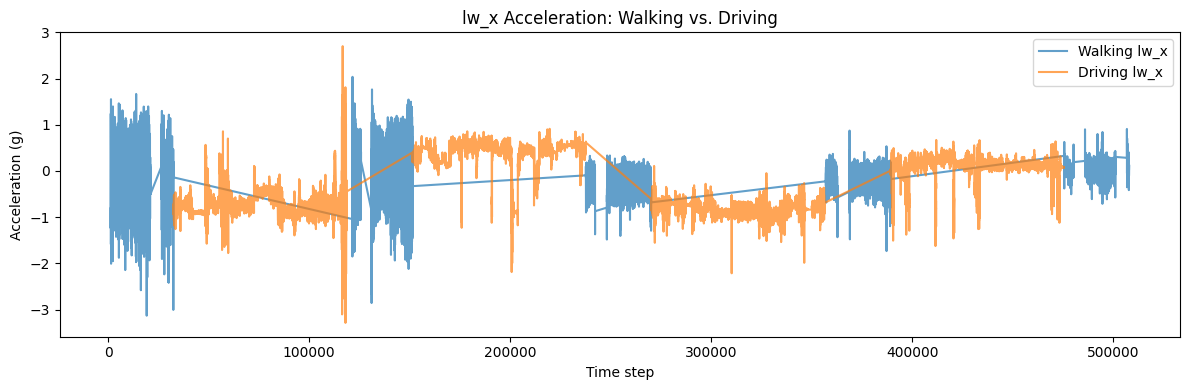

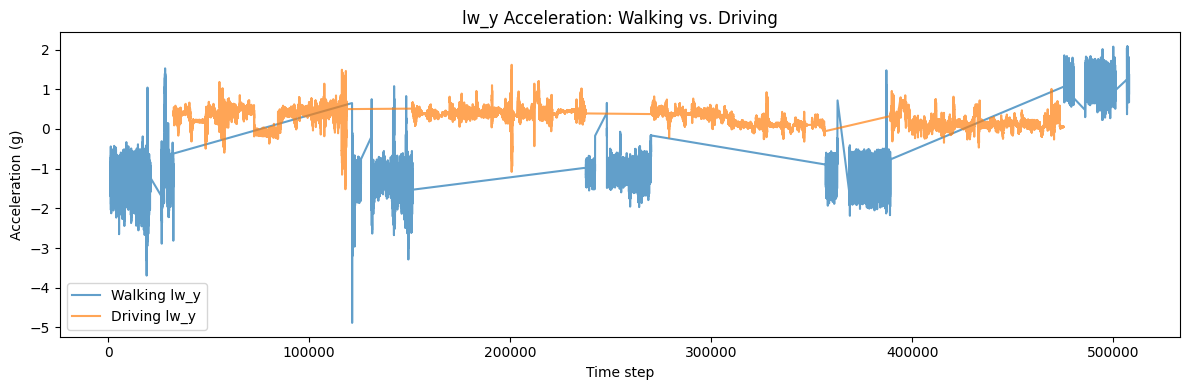

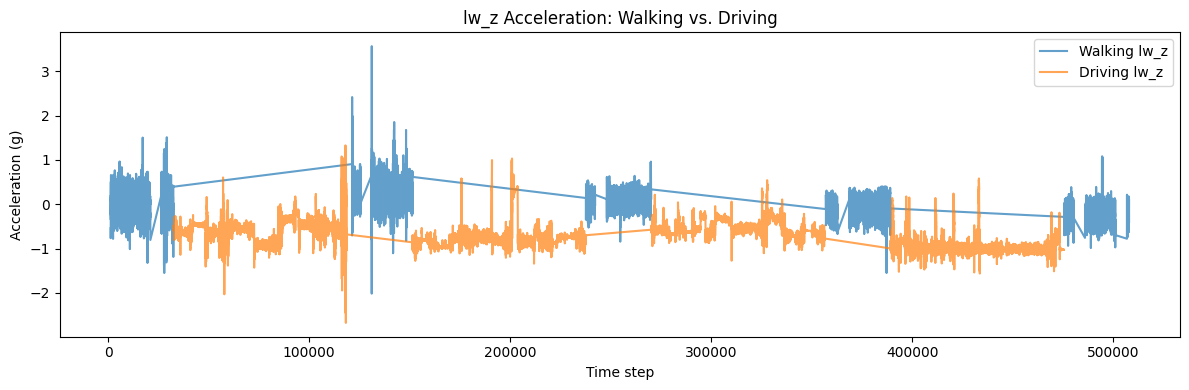

Training models and evaluating performance...
Random Forest Accuracy: 0.9983982915109451
              precision    recall  f1-score   support

     Walking       1.00      1.00      1.00       485
     Driving       1.00      1.00      1.00      1388

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873

SVM Accuracy: 0.9983982915109451
              precision    recall  f1-score   support

     Walking       1.00      1.00      1.00       485
     Driving       1.00      1.00      1.00      1388

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873

k-NN Accuracy: 0.99893219434063
              precision    recall  f1-score   support

     Walking       1.00      1.00      1.00       485
     Driving       1.00      1.00      1.00      1388

    accuracy                

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from scikeras.wrappers import KerasClassifier
import joblib

# Function to visualize the accelerometer data
def visualise_activity_data(df):
    """
    Visualize the accelerometer data for walking and driving activities.

    Parameters:
    - df (DataFrame): The pandas DataFrame containing the sensor data.
    """
    activities = {1: "Walking", 4: "Driving"}
    axes = ['lw_x', 'lw_y', 'lw_z']
    
    for ax in axes:
        plt.figure(figsize=(12, 4))
        for activity_code, activity_name in activities.items():
            subset = df[df['activity'] == activity_code]
            plt.plot(subset[ax], label=f"{activity_name} {ax}", alpha=0.7)
        plt.legend()
        plt.title(f"{ax} Acceleration: Walking vs. Driving")
        plt.xlabel("Time step")
        plt.ylabel("Acceleration (g)")
        plt.tight_layout()
        plt.show()

# Function to extract features from a data window
def extract_features(window):
    """
    Extract statistical and frequency domain features from a window of sensor data.

    Parameters:
    - window (numpy array): The data window from which to extract features.
    
    Returns:
    - numpy array: Extracted features.
    """
    # Time domain features
    time_features = [
        window.mean(), window.std(), window.min(), window.max(),
        np.quantile(window, 0.25), np.quantile(window, 0.75), np.median(window)
    ]
    
    # Frequency domain features using FFT
    fft_values = np.abs(np.fft.rfft(window))
    fft_values = fft_values[:len(fft_values) // 2]
    freq_features = [
        np.mean(fft_values), np.std(fft_values), np.min(fft_values), np.max(fft_values)
    ]
    
    return np.array(time_features + freq_features)

# Function to window the data and extract features
def window_data(df, window_size=100):
    """
    Segment the data into windows and extract features for each window.

    Parameters:
    - df (DataFrame): The pandas DataFrame with the sensor data.
    - window_size (int): The number of samples in each window.

    Returns:
    - tuple: (features, labels) where features is a numpy array of extracted features,
             and labels is a numpy array of the activity labels for each window.
    """
    features, labels = [], []
    for start in range(0, len(df) - window_size, window_size // 2):
        lw_x = df['lw_x'].iloc[start:start + window_size]
        lw_y = df['lw_y'].iloc[start:start + window_size]
        lw_z = df['lw_z'].iloc[start:start + window_size]
        
        window_features = np.concatenate([
            extract_features(lw_x), extract_features(lw_y), extract_features(lw_z)
        ])
        features.append(window_features)
        
        # Majority label in the window
        labels.append(df['activity'].iloc[start:start + window_size].mode()[0])
    
    return np.array(features), np.array(labels)

# Function to preprocess data and train models
def preprocess_and_train_model(df):
    """
    Preprocess the data, train different models, and print their performance.

    Parameters:
    - df (DataFrame): The DataFrame containing the sensor data.

    Returns:
    - dict: A dictionary of trained models.
    - StandardScaler: The scaler used for preprocessing.
    """
    # Filter the data for relevant activities
    df = df[df['activity'].isin([1, 4])]

    # Feature extraction
    features, labels = window_data(df, window_size=100)
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    # Dictionary to hold models
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "SVM": SVC(),
        "k-NN": KNeighborsClassifier(),
    }
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred, target_names=['Walking', 'Driving']))
        results[name] = model
    
    # Cross-validation for Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(rf, features, labels, cv=5)
    print(f"Random Forest cross-validation accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}")
    
    # Enhanced Neural Network
    def create_model(input_shape):
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    
    input_shape = (features.shape[1],)
    nn = KerasClassifier(model=create_model, epochs=100, batch_size=10, verbose=0)
    nn.set_params(model__input_shape=input_shape)
    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Enhanced Neural Network Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred, target_names=['Walking', 'Driving']))
    results["Neural Network"] = nn
    
    # Determine the best model based on test accuracy
    best_model = max(results, key=lambda x: accuracy_score(y_test, results[x].predict(X_test)))
    joblib.dump(results[best_model], 'best_movement_model.pkl')
    joblib.dump(scaler, 'movement_scaler.pkl')
    
    return results, scaler

# Function to predict activities for new data
def predict_movement(new_df, model_file='best_movement_model.pkl', scaler_file='movement_scaler.pkl', window_size=100):
    """
    Predict the activity for new data using the trained model.

    Parameters:
    - new_df (DataFrame): New DataFrame with the sensor data.
    - model_file (str): Path to the saved model.
    - scaler_file (str): Path to the saved scaler.
    - window_size (int): The window size used for feature extraction.

    Returns:
    - numpy array: Predicted activities for each window.
    """
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    
    new_df = new_df[new_df['activity'].isin([1, 4])]
    
    features, _ = window_data(new_df, window_size=window_size)
    features = scaler.transform(features)
    
    predictions = model.predict(features)
    return predictions

# Main Execution Block
if __name__ == "__main__":
    # Load and process the data
    df = pd.read_csv("./data/movementSensorData.csv")
    print(df.columns)

    # Visualize the accelerometer data for walking and driving
    print("Visualizing the sensor data for walking and driving activities...")
    visualise_activity_data(df)

    # Preprocess the data, train the models, and evaluate their performance
    print("Training models and evaluating performance...")
    models, scaler = preprocess_and_train_model(df)

    # Load new data to demonstrate prediction (for demonstration, using the same data)
    new_data = pd.read_csv("./data/movementSensorData.csv")
    
    # Predict the movement type for the new data
    print("Predicting activities for new data...")
    predictions = predict_movement(new_data)
    
    # Print the predictions for each window
    print("\nPredictions for each window (1 = Walking, 4 = Driving):")
    print(predictions)

In [2]:
def visualise_activity_data(df):
    """
    Visualize the accelerometer data for walking and driving activities.
    Parameters:
    - df (DataFrame): The pandas DataFrame containing the sensor data.
    """
    activities = {1: "Walking", 4: "Driving"}
    axes = ['lw_x', 'lw_y', 'lw_z']
    
    for ax in axes:
        plt.figure(figsize=(12, 4))
        for activity_code, activity_name in activities.items():
            subset = df[df['activity'] == activity_code]
            plt.plot(subset[ax], label=f"{activity_name} {ax}", alpha=0.7)
        plt.legend()
        plt.title(f"{ax} Acceleration: Walking vs. Driving")
        plt.xlabel("Time step")
        plt.ylabel("Acceleration (g)")
        plt.tight_layout()
        plt.show()

In [3]:
def extract_features(window):
    """
    Extract statistical and frequency domain features from a window of sensor data.
    Parameters:
    - window (numpy array): The data window from which to extract features.
    
    Returns:
    - numpy array: Extracted features.
    """
    # Time domain features
    time_features = [
        window.mean(), window.std(), window.min(), window.max(),
        np.quantile(window, 0.25), np.quantile(window, 0.75), np.median(window)
    ]
    
    # Frequency domain features using FFT
    fft_values = np.abs(np.fft.rfft(window))
    fft_values = fft_values[:len(fft_values) // 2]
    freq_features = [
        np.mean(fft_values), np.std(fft_values), np.min(fft_values), np.max(fft_values)
    ]
    
    return np.array(time_features + freq_features)

In [4]:
def window_data(df, window_size=100):
    """
    Segment the data into windows and extract features for each window.
    Parameters:
    - df (DataFrame): The pandas DataFrame with the sensor data.
    - window_size (int): The number of samples in each window.
    Returns:
    - tuple: (features, labels) where features is a numpy array of extracted features,
             and labels is a numpy array of the activity labels for each window.
    """
    features, labels = [], []
    for start in range(0, len(df) - window_size, window_size // 2):
        lw_x = df['lw_x'].iloc[start:start + window_size]
        lw_y = df['lw_y'].iloc[start:start + window_size]
        lw_z = df['lw_z'].iloc[start:start + window_size]
        
        window_features = np.concatenate([
            extract_features(lw_x), extract_features(lw_y), extract_features(lw_z)
        ])
        features.append(window_features)
        
        # Majority label in the window
        labels.append(df['activity'].iloc[start:start + window_size].mode()[0])
    
    return np.array(features), np.array(labels)

In [5]:
def preprocess_and_train_model(df):
    """
    Preprocess the data, train different models, and print their performance.
    Parameters:
    - df (DataFrame): The DataFrame containing the sensor data.
    Returns:
    - dict: A dictionary of trained models.
    - StandardScaler: The scaler used for preprocessing.
    """
    # Filter the data for relevant activities
    df = df[df['activity'].isin([1, 4])]

    # Feature extraction
    features, labels = window_data(df, window_size=100)
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    # Dictionary to hold models
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "SVM": SVC(),
        "k-NN": KNeighborsClassifier(),
    }
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred, target_names=['Walking', 'Driving']))
        results[name] = model
    
    # Cross-validation for Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(rf, features, labels, cv=5)
    print(f"Random Forest cross-validation accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}")
    
    # Enhanced Neural Network
    def create_model(input_shape):
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    
    input_shape = (features.shape[1],)
    nn = KerasClassifier(model=create_model, epochs=100, batch_size=10, verbose=0)
    nn.set_params(model__input_shape=input_shape)
    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Enhanced Neural Network Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred, target_names=['Walking', 'Driving']))
    results["Neural Network"] = nn
    
    # Determine the best model based on test accuracy
    best_model = max(results, key=lambda x: accuracy_score(y_test, results[x].predict(X_test)))
    joblib.dump(results[best_model], 'best_movement_model.pkl')
    joblib.dump(scaler, 'movement_scaler.pkl')
    
    return results, scaler

In [6]:
def predict_movement(new_df, model_file='best_movement_model.pkl', scaler_file='movement_scaler.pkl', window_size=100):
    """
    Predict the activity for new data using the trained model.
    Parameters:
    - new_df (DataFrame): New DataFrame with the sensor data.
    - model_file (str): Path to the saved model.
    - scaler_file (str): Path to the saved scaler.
    - window_size (int): The window size used for feature extraction.
    Returns:
    - numpy array: Predicted activities for each window.
    """
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    
    new_df = new_df[new_df['activity'].isin([1, 4])]
    
    features, _ = window_data(new_df, window_size=window_size)
    features = scaler.transform(features)
    
    predictions = model.predict(features)
    return predictions

Main execution block

Index(['Unnamed: 0', 'activity', 'time_s', 'lw_x', 'lw_y', 'lw_z'], dtype='object')
Visualizing the sensor data for walking and driving activities...


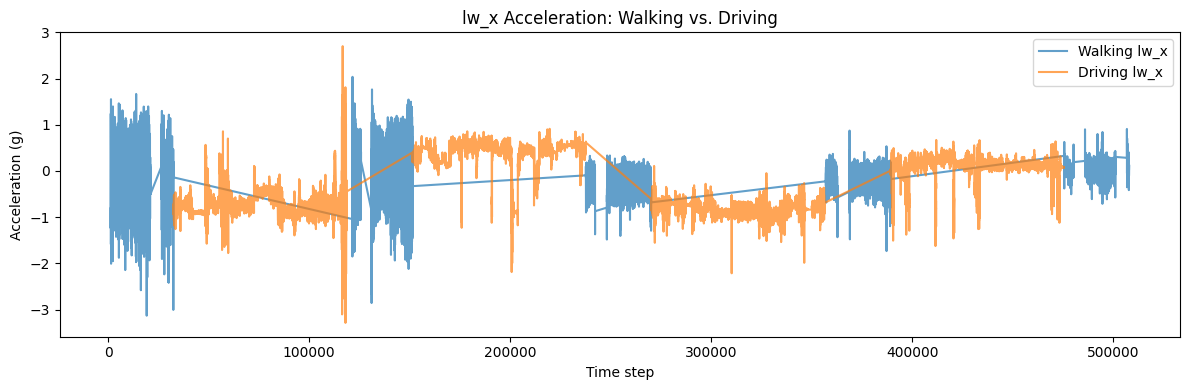

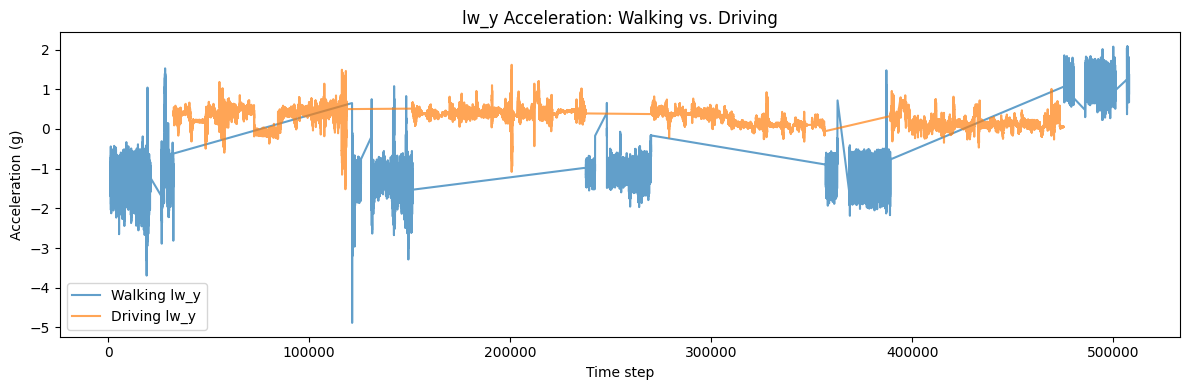

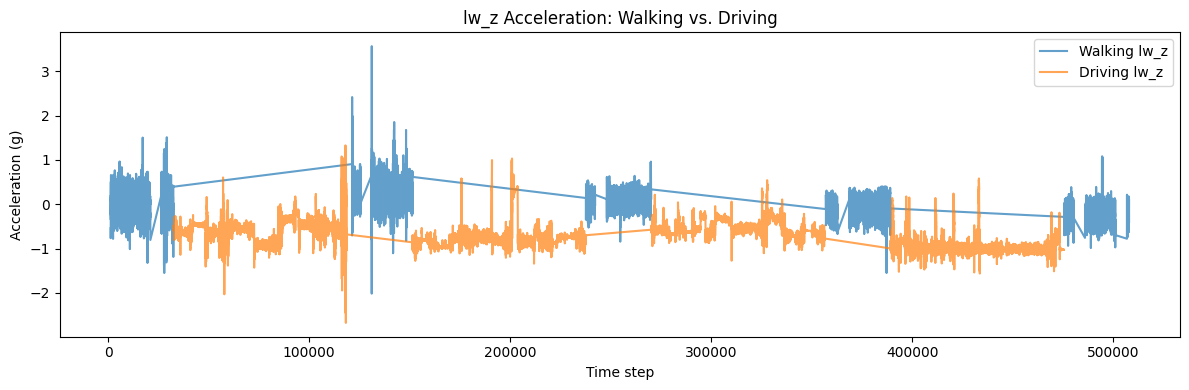

Training models and evaluating performance...
Random Forest Accuracy: 0.99786438868126
              precision    recall  f1-score   support

     Walking       0.99      1.00      1.00       485
     Driving       1.00      1.00      1.00      1388

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873

SVM Accuracy: 0.9983982915109451
              precision    recall  f1-score   support

     Walking       1.00      1.00      1.00       485
     Driving       1.00      1.00      1.00      1388

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873

k-NN Accuracy: 0.99893219434063
              precision    recall  f1-score   support

     Walking       1.00      1.00      1.00       485
     Driving       1.00      1.00      1.00      1388

    accuracy                  

In [7]:
if __name__ == "__main__":
    # Load and process the data
    df = pd.read_csv("./data/movementSensorData.csv")
    print(df.columns)

    # Visualize the accelerometer data for walking and driving
    print("Visualizing the sensor data for walking and driving activities...")
    visualise_activity_data(df)

    # Preprocess the data, train the models, and evaluate their performance
    print("Training models and evaluating performance...")
    models, scaler = preprocess_and_train_model(df)

    # Load new data to demonstrate prediction (for demonstration, using the same data)
    new_data = pd.read_csv("./data/movementSensorData.csv")
    
    # Predict the movement type for the new data
    print("Predicting activities for new data...")
    predictions = predict_movement(new_data)
    
    # Print the predictions for each window
    print("\nPredictions for each window (1 = Walking, 4 = Driving):")
    print(predictions)